# TP FloatPairs - Recherche Locale

## 1. Imports

In [1]:
# Installation si nécessaire : !pip install jmetalpy numpy pandas matplotlib

from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator.mutation import PolynomialMutation
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
print("✓ Imports OK")

✓ Imports OK


## 2. Définition du Problème FloatPairs

In [2]:
class FloatPairsMax(Problem):
    """
    Problème FloatPairs: Maximiser le nombre de paires adjacentes de signes différents
    dans une séquence de nombres flottants.
    
    Pour une séquence de n nombres, le maximum théorique est n-1 paires
    (obtenu par alternance parfaite des signes).
    """
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        
        self.number_of_objectives = 1
        # IMPORTANT: On MINIMISE l'objectif pour être compatible avec JMetalPy
        # On va donc retourner -(nombre de paires)
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['NegativePairsCount']
        
    def number_of_variables(self) -> int:
        return self.number_of_floats
    
    def number_of_objectives(self) -> int:
        return 1
    
    def number_of_constraints(self) -> int:
        return 0
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        """
        Calcule le nombre de paires adjacentes de signes différents.
        Retourne la valeur NÉGATIVE pour minimisation.
        """
        variables = solution.variables
        pairs_count = 0
        
        # Parcours des paires adjacentes
        for i in range(len(variables) - 1):
            # Vérification si les signes sont différents
            if (variables[i] * variables[i + 1] < 0) or \
               (variables[i] == 0 and variables[i + 1] < 0) or \
               (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        
        # On retourne la valeur NÉGATIVE pour minimisation
        solution.objectives[0] = -pairs_count
        return solution
    
    def create_solution(self) -> FloatSolution:
        """
        Crée une solution aléatoire
        """
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints()
        )
        
        # Génération de nombres aléatoires dans l'intervalle
        new_solution.variables = [
            random.uniform(self.lower_bound[i], self.upper_bound[i])
            for i in range(self.number_of_variables())
        ]
        
        return new_solution
    
    def name(self) -> str:
        return 'FloatPairsMax'

print("✓ Classe FloatPairsMax définie")

✓ Classe FloatPairsMax définie


## 3. Test du Problème

In [3]:
# Test rapide du problème
print("=== Test du problème FloatPairs ===")

n = 8
bi = -10.00
bs = 10.00

problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)

# Test avec solution optimale théorique (alternance)
optimal_solution = problem.create_solution()
optimal_solution.variables = [bs if i % 2 == 0 else bi for i in range(n)]
optimal_solution = problem.evaluate(optimal_solution)

print(f"Solution optimale: {[f'{v:.2f}' for v in optimal_solution.variables]}")
print(f"Fitness (négatif): {optimal_solution.objectives[0]}")
print(f"Nombre de paires réel: {-optimal_solution.objectives[0]}")
print(f"Maximum théorique: {n-1} paires\n")

# Test avec solution aléatoire
random_solution = problem.create_solution()
random_solution = problem.evaluate(random_solution)
print(f"Solution aléatoire: {[f'{v:.2f}' for v in random_solution.variables]}")
print(f"Nombre de paires: {-random_solution.objectives[0]}")

=== Test du problème FloatPairs ===
Solution optimale: ['10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00']
Fitness (négatif): -7
Nombre de paires réel: 7
Maximum théorique: 7 paires

Solution aléatoire: ['7.67', '4.23', '1.55', '5.45', '5.04', '-6.86', '-1.37', '-4.91']
Nombre de paires: 1


## 4. Protocole Expérimental

### 4.1 Paramètres Communs

In [4]:
# Paramètres du problème
N_FLOATS = 8
MIN_VALUE = -10.0
MAX_VALUE = 10.0
OPTIMAL_VALUE = -(N_FLOATS - 1)  # -7 pour minimisation (7 paires pour maximisation)

# Paramètres expérimentaux
MAX_EVALUATIONS = 5000
N_RUNS = 20

# Paramètre de mutation par défaut
MUTATION_DISTRIBUTION_INDEX = 20.0

# Tableau 1 : Paramètres communs
common_params = pd.DataFrame({
    'Paramètre': [
        'Nombre de floats (n)',
        'Intervalle des valeurs',
        'Optimal théorique',
        'Nombre d\'évaluations',
        'Nombre de runs',
        'Mutation distribution index'
    ],
    'Valeur': [
        N_FLOATS,
        f'[{MIN_VALUE}, {MAX_VALUE}]',
        f'{-OPTIMAL_VALUE} paires',
        MAX_EVALUATIONS,
        N_RUNS,
        MUTATION_DISTRIBUTION_INDEX
    ]
})

print("Tableau 1 : Paramètres communs")
print("="*60)
display(common_params)

Tableau 1 : Paramètres communs


,Paramètre,Valeur
0,Nombre de floats (n),8
1,Intervalle des valeurs,"[-10.0, 10.0]"
2,Optimal théorique,7 paires
3,Nombre d'évaluations,5000
4,Nombre de runs,20
5,Mutation distribution index,20.0


### 4.2 Configurations de Recherche Locale Testées

Nous allons tester **5 configurations différentes** de probabilité de mutation :
- **LS1** : `mutation_probability = None` (utilise 1/n par défaut = 0.125)
- **LS2** : `mutation_probability = 0.25` (faible mutation)
- **LS3** : `mutation_probability = 0.5` (mutation modérée)
- **LS4** : `mutation_probability = 0.75` (forte mutation)
- **LS5** : `mutation_probability = 1.0` (mutation maximale)

In [5]:
# Tableau 2 : Configurations testées
configurations = {
    'LS1': {
        'nom': 'Mutation par défaut (1/n)',
        'mutation_probability': None,  # Utilise 1/n par défaut
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS2': {
        'nom': 'Mutation faible (0.25)',
        'mutation_probability': 0.25,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS3': {
        'nom': 'Mutation modérée (0.5)',
        'mutation_probability': 0.5,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS4': {
        'nom': 'Mutation forte (0.75)',
        'mutation_probability': 0.75,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS5': {
        'nom': 'Mutation maximale (1.0)',
        'mutation_probability': 1.0,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    }
}

# Création du tableau de configurations
config_data = []
for key, config in configurations.items():
    # Calcul de la probabilité effective
    prob_display = config['mutation_probability'] if config['mutation_probability'] is not None else 1.0 / N_FLOATS
    
    config_data.append({
        'Config': key,
        'Description': config['nom'],
        'Mutation Probability': f"{prob_display:.4f}",
        'Mutation Index': config['mutation_distribution_index']
    })

config_df = pd.DataFrame(config_data)

print("Tableau 2 : Configurations de Recherche Locale")
print("="*60)
display(config_df)

Tableau 2 : Configurations de Recherche Locale


,Config,Description,Mutation Probability,Mutation Index
0,LS1,Mutation par défaut (1/n),0.1250,20.0
1,LS2,Mutation faible (0.25),0.2500,20.0
2,LS3,Mutation modérée (0.5),0.5000,20.0
3,LS4,Mutation forte (0.75),0.7500,20.0
4,LS5,Mutation maximale (1.0),1.0000,20.0


## 5. Fonction d'Exécution d'un Run

In [6]:
def run_local_search(problem, config, max_evaluations, verbose=False):
    """
    Exécute un run de recherche locale avec une configuration donnée.
    
    Args:
        problem: Instance du problème FloatPairsMax
        config: Dictionnaire de configuration
        max_evaluations: Nombre maximum d'évaluations
        verbose: Afficher les logs détaillés
    
    Returns:
        tuple: (fitness, temps_execution)
    """
    # Configuration de l'opérateur de mutation
    # Si mutation_probability est None, on utilise 1/n
    mutation_prob = config['mutation_probability']
    if mutation_prob is None:
        mutation_prob = 1.0 / problem.number_of_variables()
    
    mutation = PolynomialMutation(
        probability=mutation_prob,
        distribution_index=config['mutation_distribution_index']
    )
    
    # Création de l'algorithme de recherche locale
    algorithm = LocalSearch(
        problem=problem,
        mutation=mutation,
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
    )
    
    # Exécution
    start_time = time.time()
    algorithm.run()
    execution_time = time.time() - start_time
    
    # Récupération du résultat
    result = algorithm.result()
    fitness = result.objectives[0]  # Valeur négative (minimisation)
    
    if verbose:
        print(f"  Fitness: {fitness} ({-fitness} paires)")
        print(f"  Temps: {execution_time:.4f}s")
    
    return fitness, execution_time

print("✓ Fonction run_local_search définie")

✓ Fonction run_local_search définie


## 6. Exécution des Expérimentations

### 6.1 Runs pour Chaque Configuration

Nous allons effectuer **20 runs** pour chaque configuration de recherche locale.

In [7]:
# Création du problème
problem = FloatPairsMax(number_of_floats=N_FLOATS, min_value=MIN_VALUE, max_value=MAX_VALUE)

# Dictionnaire pour stocker tous les résultats
results = {}

# Exécution des runs pour chaque configuration
for config_name, config in configurations.items():
    print(f"\n{'='*80}")
    print(f"Configuration: {config_name} - {config['nom']}")
    print(f"{'='*80}")
    
    fitness_values = []
    execution_times = []
    
    for run in range(1, N_RUNS + 1):
        print(f"\nRun {run}/{N_RUNS}", end=" ")
        
        fitness, exec_time = run_local_search(
            problem=problem,
            config=config,
            max_evaluations=MAX_EVALUATIONS,
            verbose=False
        )
        
        fitness_values.append(fitness)
        execution_times.append(exec_time)
        
        # Affichage simplifié
        print(f"→ Fitness: {fitness:.2f} ({-fitness:.0f} paires) | Temps: {exec_time:.4f}s")
    
    # Stockage des résultats
    results[config_name] = {
        'fitness_values': fitness_values,
        'execution_times': execution_times
    }
    
    # Statistiques de la configuration
    print(f"\n{'─'*80}")
    print(f"Statistiques pour {config_name}:")
    print(f"  Fitness moyen: {np.mean(fitness_values):.2f} paires")
    print(f"  Médiane: {np.median(fitness_values):.2f}")
    print(f"  Écart-type: {np.std(fitness_values):.4f}")
    print(f"  Min: {np.min(fitness_values):.2f} | Max: {np.max(fitness_values):.2f}")
    print(f"  Temps moyen: {np.mean(execution_times):.4f}s")
    print(f"{'─'*80}")

print(f"\n{'='*80}")
print("✓ Toutes les expérimentations sont terminées !")
print(f"{'='*80}")

[2026-02-01 21:57:39,031] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,031] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,031] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,031] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met



Configuration: LS1 - Mutation par défaut (1/n)

Run 1/20 

[2026-02-01 21:57:39,164] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,166] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,166] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,166] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,166] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1350s

Run 2/20 

[2026-02-01 21:57:39,297] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,297] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,304] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,304] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,304] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -6.00 (6 paires) | Temps: 0.1313s

Run 3/20 

[2026-02-01 21:57:39,431] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,431] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,431] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,431] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,431] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1339s

Run 4/20 

[2026-02-01 21:57:39,559] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,559] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,559] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,559] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,564] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1282s

Run 5/20 

[2026-02-01 21:57:39,685] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,685] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,685] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,685] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,685] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1253s

Run 6/20 

[2026-02-01 21:57:39,817] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,818] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,819] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,819] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,819] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -6.00 (6 paires) | Temps: 0.1333s

Run 7/20 

[2026-02-01 21:57:39,965] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:39,965] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:39,965] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:39,965] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:39,965] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -5.00 (5 paires) | Temps: 0.1467s

Run 8/20 

[2026-02-01 21:57:40,092] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,092] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,092] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,092] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,092] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1271s

Run 9/20 

[2026-02-01 21:57:40,228] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,228] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,228] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,228] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,230] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -6.00 (6 paires) | Temps: 0.1364s

Run 10/20 

[2026-02-01 21:57:40,361] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,361] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,361] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,361] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,361] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1331s

Run 11/20 

[2026-02-01 21:57:40,484] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,484] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,484] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,490] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,490] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -6.00 (6 paires) | Temps: 0.1234s

Run 12/20 

[2026-02-01 21:57:40,640] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,640] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,647] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,647] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,647] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1551s

Run 13/20 

[2026-02-01 21:57:40,805] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,805] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,805] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,805] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,805] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1657s

Run 14/20 

[2026-02-01 21:57:40,933] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:40,933] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:40,933] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:40,933] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:40,933] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1277s

Run 15/20 

[2026-02-01 21:57:41,048] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,048] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,048] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,048] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,048] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1149s

Run 16/20 

[2026-02-01 21:57:41,182] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,182] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,183] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,183] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,185] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1337s

Run 17/20 

[2026-02-01 21:57:41,333] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,334] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,334] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,336] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,337] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1520s

Run 18/20 

[2026-02-01 21:57:41,465] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,465] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,465] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,465] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,465] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1318s

Run 19/20 

[2026-02-01 21:57:41,598] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,601] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,601] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,601] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,601] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1356s

Run 20/20 

[2026-02-01 21:57:41,765] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,768] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,768] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,768] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,773] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1666s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS1:
  Fitness moyen: -6.70 paires
  Médiane: -7.00
  Écart-type: 0.5568
  Min: -7.00 | Max: -5.00
  Temps moyen: 0.1368s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS2 - Mutation faible (0.25)

Run 1/20 

[2026-02-01 21:57:41,951] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:41,951] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:41,959] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:41,959] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:41,959] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:42,086] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,086] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,089] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,089] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,089] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -6.00 (6 paires) | Temps: 0.1834s

Run 2/20 → Fitness: -7.00 (7 paires) | Temps: 0.1350s

Run 3/20 

[2026-02-01 21:57:42,225] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,233] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,233] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,235] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,235] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:42,381] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,383] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,383] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,383] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,386] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1466s

Run 4/20 → Fitness: -7.00 (7 paires) | Temps: 0.1505s

Run 5/20 

[2026-02-01 21:57:42,507] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,507] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,507] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,515] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,515] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:42,651] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,664] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,664] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,664] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,664] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1237s

Run 6/20 → Fitness: -7.00 (7 paires) | Temps: 0.1570s

Run 7/20 

[2026-02-01 21:57:42,786] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,786] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,786] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,786] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,786] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:42,892] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:42,892] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:42,907] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:42,907] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:42,907] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1223s

Run 8/20 → Fitness: -7.00 (7 paires) | Temps: 0.1056s

Run 9/20 

[2026-02-01 21:57:43,044] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:43,044] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:43,044] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:43,044] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:43,044] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:43,240] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1524s

Run 10/20 

[2026-02-01 21:57:43,248] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:43,248] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:43,248] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:43,248] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:43,450] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2037s

Run 11/20 

[2026-02-01 21:57:43,450] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:43,450] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:43,450] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:43,450] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:43,632] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2011s

Run 12/20 

[2026-02-01 21:57:43,633] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:43,633] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:43,633] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:43,636] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:43,819] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1837s

Run 13/20 

[2026-02-01 21:57:43,823] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:43,823] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:43,823] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:43,828] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:43,990] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:43,990] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:43,990] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:43,990] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:43,990] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1899s

Run 14/20 → Fitness: -7.00 (7 paires) | Temps: 0.1666s

Run 15/20 

[2026-02-01 21:57:44,188] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:44,190] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:44,190] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:44,190] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:44,190] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:44,385] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1998s

Run 16/20 

[2026-02-01 21:57:44,385] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:44,388] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:44,388] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:44,388] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:44,588] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1959s

Run 17/20 

[2026-02-01 21:57:44,588] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:44,588] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:44,588] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:44,598] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:44,736] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:44,736] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:44,736] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:44,736] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:44,740] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2028s

Run 18/20 → Fitness: -7.00 (7 paires) | Temps: 0.1477s

Run 19/20 

[2026-02-01 21:57:44,919] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:44,923] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:44,923] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:44,923] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:44,930] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1834s

Run 20/20 

[2026-02-01 21:57:45,215] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:45,222] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:45,231] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:45,232] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:45,235] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2989s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS2:
  Fitness moyen: -6.95 paires
  Médiane: -7.00
  Écart-type: 0.2179
  Min: -7.00 | Max: -6.00
  Temps moyen: 0.1725s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS3 - Mutation modérée (0.5)

Run 1/20 

[2026-02-01 21:57:45,481] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:45,481] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:45,481] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:45,481] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:45,481] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:45,618] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:45,618] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:45,618] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:45,618] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:45,618] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2582s

Run 2/20 → Fitness: -7.00 (7 paires) | Temps: 0.1371s

Run 3/20 

[2026-02-01 21:57:45,734] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:45,734] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:45,734] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:45,734] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:45,734] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:45,847] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:45,847] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:45,847] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:45,847] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:45,847] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1162s

Run 4/20 → Fitness: -7.00 (7 paires) | Temps: 0.1129s

Run 5/20 

[2026-02-01 21:57:45,958] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:45,958] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:45,958] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:45,958] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:45,958] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:46,065] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,078] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,078] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,078] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,078] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1114s

Run 6/20 → Fitness: -7.00 (7 paires) | Temps: 0.1201s

Run 7/20 

[2026-02-01 21:57:46,198] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,198] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,198] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,198] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,198] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:46,294] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,294] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,310] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,310] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,310] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1200s

Run 8/20 → Fitness: -7.00 (7 paires) | Temps: 0.0958s

Run 9/20 

[2026-02-01 21:57:46,407] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,407] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,407] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,407] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,407] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:46,529] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,529] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,529] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,529] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,529] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1128s

Run 10/20 → Fitness: -7.00 (7 paires) | Temps: 0.1217s

Run 11/20 

[2026-02-01 21:57:46,682] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,682] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,682] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,682] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,682] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:46,845] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:46,845] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:46,845] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:46,845] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:46,845] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1531s

Run 12/20 → Fitness: -7.00 (7 paires) | Temps: 0.1630s

Run 13/20 

[2026-02-01 21:57:47,058] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:47,065] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:47,065] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:47,065] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:47,065] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:47,218] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:47,218] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:47,218] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:47,218] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:47,218] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2205s

Run 14/20 → Fitness: -7.00 (7 paires) | Temps: 0.1525s

Run 15/20 

[2026-02-01 21:57:47,376] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:47,376] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:47,376] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:47,376] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:47,376] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:47,574] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1587s

Run 16/20 

[2026-02-01 21:57:47,583] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:47,584] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:47,584] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:47,584] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2055s

Run 17/20 

[2026-02-01 21:57:47,799] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:47,802] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:47,802] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:47,802] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:47,802] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:47,994] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2182s

Run 18/20 

[2026-02-01 21:57:47,998] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:47,999] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:48,001] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:48,001] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1963s

Run 19/20 

[2026-02-01 21:57:48,201] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:48,201] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:48,201] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:48,201] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:48,207] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:48,407] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2033s

Run 20/20 

[2026-02-01 21:57:48,407] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:48,415] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:48,415] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:48,418] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2058s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS3:
  Fitness moyen: -7.00 paires
  Médiane: -7.00
  Écart-type: 0.0000
  Min: -7.00 | Max: -7.00
  Temps moyen: 0.1592s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS4 - Mutation forte (0.75)

Run 1/20 

[2026-02-01 21:57:48,640] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:48,648] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:48,649] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:48,650] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:48,651] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:48,865] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2406s

Run 2/20 

[2026-02-01 21:57:48,865] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:48,865] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:48,865] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:48,865] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2179s

Run 3/20 

[2026-02-01 21:57:49,085] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:49,085] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:49,085] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:49,085] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:49,091] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2193s

Run 4/20 

[2026-02-01 21:57:49,308] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:49,308] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:49,308] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:49,308] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:49,316] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2236s

Run 5/20 

[2026-02-01 21:57:49,574] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:49,574] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:49,574] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:49,574] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:49,574] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:49,774] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2657s

Run 6/20 

[2026-02-01 21:57:49,774] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:49,774] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:49,782] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:49,785] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1996s

Run 7/20 

[2026-02-01 21:57:49,997] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,003] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,004] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,006] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,006] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:50,133] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,134] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,134] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,134] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,134] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2284s

Run 8/20 → Fitness: -7.00 (7 paires) | Temps: 0.1306s

Run 9/20 

[2026-02-01 21:57:50,268] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,268] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,268] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,268] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,274] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:50,407] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,407] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,412] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,412] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,412] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1341s

Run 10/20 → Fitness: -7.00 (7 paires) | Temps: 0.1394s

Run 11/20 

[2026-02-01 21:57:50,546] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,549] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,550] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,551] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,551] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:50,674] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,674] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,674] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,674] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,674] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1384s

Run 12/20 → Fitness: -7.00 (7 paires) | Temps: 0.1251s

Run 13/20 

[2026-02-01 21:57:50,828] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:50,829] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:50,830] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:50,831] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:50,832] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:51,002] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:51,008] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:51,008] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:51,008] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:51,008] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1552s

Run 14/20 → Fitness: -7.00 (7 paires) | Temps: 0.1783s

Run 15/20 

[2026-02-01 21:57:51,258] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:51,258] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:51,258] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:51,258] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:51,258] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2503s

Run 16/20 

[2026-02-01 21:57:51,489] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:51,489] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:51,489] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:51,495] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:51,495] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2313s

Run 17/20 

[2026-02-01 21:57:51,733] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:51,735] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:51,735] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:51,735] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:51,735] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:51,951] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2460s

Run 18/20 

[2026-02-01 21:57:51,951] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:51,951] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:51,951] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:51,951] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:52,117] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:52,117] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:52,117] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:52,117] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:52,117] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2163s

Run 19/20 → Fitness: -7.00 (7 paires) | Temps: 0.1659s

Run 20/20 

[2026-02-01 21:57:52,274] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:52,274] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:52,283] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:52,283] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:52,284] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:52,451] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1570s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS4:
  Fitness moyen: -7.00 paires
  Médiane: -7.00
  Écart-type: 0.0000
  Min: -7.00 | Max: -7.00
  Temps moyen: 0.1931s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS5 - Mutation maximale (1.0)

Run 1/20 

[2026-02-01 21:57:52,452] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:52,452] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:52,452] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:52,452] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:52,640] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1774s

Run 2/20 

[2026-02-01 21:57:52,648] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:52,648] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:52,648] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:52,648] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:52,825] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:52,825] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:52,825] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:52,825] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:52,833] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1886s

Run 3/20 → Fitness: -7.00 (7 paires) | Temps: 0.1762s

Run 4/20 

[2026-02-01 21:57:52,991] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:52,991] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:52,991] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:52,991] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:52,991] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:53,141] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:53,141] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:53,141] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:53,141] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:53,141] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1668s

Run 5/20 → Fitness: -7.00 (7 paires) | Temps: 0.1501s

Run 6/20 

[2026-02-01 21:57:53,302] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:53,307] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:53,307] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:53,307] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:53,307] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:53,475] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:53,475] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:53,475] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:53,475] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:53,475] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1655s

Run 7/20 → Fitness: -7.00 (7 paires) | Temps: 0.1676s

Run 8/20 

[2026-02-01 21:57:53,636] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:53,636] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:53,636] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:53,641] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:53,641] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:53,808] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:53,808] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:53,808] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:53,808] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:53,808] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.1618s

Run 9/20 → Fitness: -7.00 (7 paires) | Temps: 0.1718s

Run 10/20 

[2026-02-01 21:57:53,995] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:53,999] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:54,002] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:54,002] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:54,002] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:54,192] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1913s

Run 11/20 

[2026-02-01 21:57:54,200] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:54,202] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:54,202] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:54,202] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2004s

Run 12/20 

[2026-02-01 21:57:54,442] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:54,442] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:54,442] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:54,442] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:54,450] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2418s

Run 13/20 

[2026-02-01 21:57:54,734] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:54,734] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:54,734] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:54,734] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:54,741] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:54,952] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2924s

Run 14/20 

[2026-02-01 21:57:54,952] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:54,952] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:54,952] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:54,952] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2182s

Run 15/20 

[2026-02-01 21:57:55,185] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:55,198] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:55,200] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:55,201] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:55,201] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -7.00 (7 paires) | Temps: 0.2459s

Run 16/20 

[2026-02-01 21:57:55,419] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-01 21:57:55,419] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:55,419] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:55,419] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:55,419] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:55,615] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2205s

Run 17/20 

[2026-02-01 21:57:55,615] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:55,615] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:55,615] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:55,615] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:55,816] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1961s

Run 18/20 

[2026-02-01 21:57:55,816] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:55,816] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:55,816] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:55,816] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:56,000] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.2012s

Run 19/20 

[2026-02-01 21:57:56,000] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-01 21:57:56,002] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-01 21:57:56,002] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-01 21:57:56,002] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-01 21:57:56,164] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -7.00 (7 paires) | Temps: 0.1842s

Run 20/20 → Fitness: -7.00 (7 paires) | Temps: 0.1636s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS5:
  Fitness moyen: -7.00 paires
  Médiane: -7.00
  Écart-type: 0.0000
  Min: -7.00 | Max: -7.00
  Temps moyen: 0.1941s
────────────────────────────────────────────────────────────────────────────────

✓ Toutes les expérimentations sont terminées !


## 7. Analyse des Résultats

### 7.1 Calcul des Statistiques Complètes

In [8]:
# Calcul des statistiques pour chaque configuration
for config_name in results:
    fitness_vals = results[config_name]['fitness_values']
    time_vals = results[config_name]['execution_times']
    
    results[config_name]['mean'] = np.mean(fitness_vals)
    results[config_name]['median'] = np.median(fitness_vals)
    results[config_name]['std'] = np.std(fitness_vals)
    results[config_name]['min'] = np.min(fitness_vals)
    results[config_name]['max'] = np.max(fitness_vals)
    results[config_name]['time_mean'] = np.mean(time_vals)
    results[config_name]['time_std'] = np.std(time_vals)
    
    # Taux de succès (atteint l'optimal)
    optimal_count = sum(1 for f in fitness_vals if f == OPTIMAL_VALUE)
    results[config_name]['success_rate'] = (optimal_count / N_RUNS) * 100

print("✓ Statistiques calculées")

✓ Statistiques calculées


### 7.2 Tableau Récapitulatif des Résultats

In [9]:
# Création du tableau récapitulatif
summary_data = []
for config_name, res in results.items():
    summary_data.append({
        'Configuration': config_name,
        'Description': configurations[config_name]['nom'],
        'Moyenne (paires)': f"{-res['mean']:.2f}",
        'Médiane': f"{-res['median']:.2f}",
        'Écart-type': f"{res['std']:.4f}",
        'Min': f"{-res['min']:.2f}",
        'Max': f"{-res['max']:.2f}",
        'Taux succès (%)': f"{res['success_rate']:.1f}",
        'Temps moyen (s)': f"{res['time_mean']:.4f}",
        'Temps σ': f"{res['time_std']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)

print("Tableau 3 : Résultats des Recherches Locales")
print("="*120)
display(summary_df)

# Export en CSV
#summary_df.to_csv('floatpairs_local_search_summary.csv', index=False)
print("\n✓ Tableau exporté dans 'floatpairs_local_search_summary.csv'")

Tableau 3 : Résultats des Recherches Locales


,Configuration,Description,Moyenne (paires),Médiane,Écart-type,Min,Max,Taux succès (%),Temps moyen (s),Temps σ
0,LS1,Mutation par défaut (1/n),6.70,7.00,0.5568,7.00,5.00,75.0,0.1368,0.0133
1,LS2,Mutation faible (0.25),6.95,7.00,0.2179,7.00,6.00,95.0,0.1725,0.0411
2,LS3,Mutation modérée (0.5),7.00,7.00,0.0000,7.00,7.00,100.0,0.1592,0.0459
3,LS4,Mutation forte (0.75),7.00,7.00,0.0000,7.00,7.00,100.0,0.1931,0.0451
4,LS5,Mutation maximale (1.0),7.00,7.00,0.0000,7.00,7.00,100.0,0.1941,0.0342



✓ Tableau exporté dans 'floatpairs_local_search_summary.csv'


### 8.1 Distribution des Résultats (Box Plot)

C:\Users\MASSIVE\AppData\Local\Temp\ipykernel_22556\473382884.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,


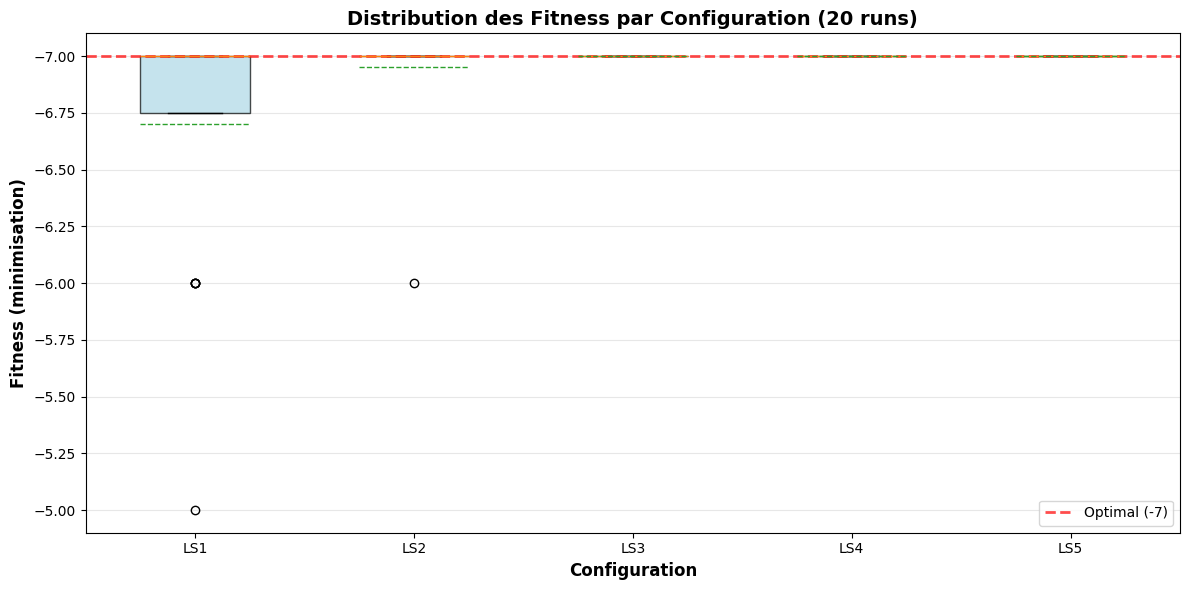


✓ Boxplots générés avec succès


In [10]:
# Graphique 1: Boxplots
fig, ax = plt.subplots(figsize=(12, 6))

# Préparation des données pour boxplot
data_for_boxplot = [results[c]['fitness_values'] for c in configurations.keys()]
labels = list(configurations.keys())

# Création des boxplots
bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,
                showmeans=True, meanline=True)

# Coloration des boîtes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lavender']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Configuration du graphique
ax.set_ylabel('Fitness (minimisation)', fontsize=12, fontweight='bold')
ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Fitness par Configuration (20 runs)', 
             fontsize=14, fontweight='bold')
ax.axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', linewidth=2, 
           label=f'Optimal ({OPTIMAL_VALUE})', alpha=0.7)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(loc='lower right', fontsize=10)

# Inverser l'axe Y pour que l'optimal soit en haut
ax.invert_yaxis()

plt.tight_layout()
#plt.savefig('floatpairs_ls_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Boxplots générés avec succès")

### 8.2 Graphiques Complémentaires (Moyenne, Distance, Temps)

C:\Users\MASSIVE\AppData\Local\Temp\ipykernel_22556\2022224857.py:80: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\MIAGE\m2-miage\OAFD\FloatPairs\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


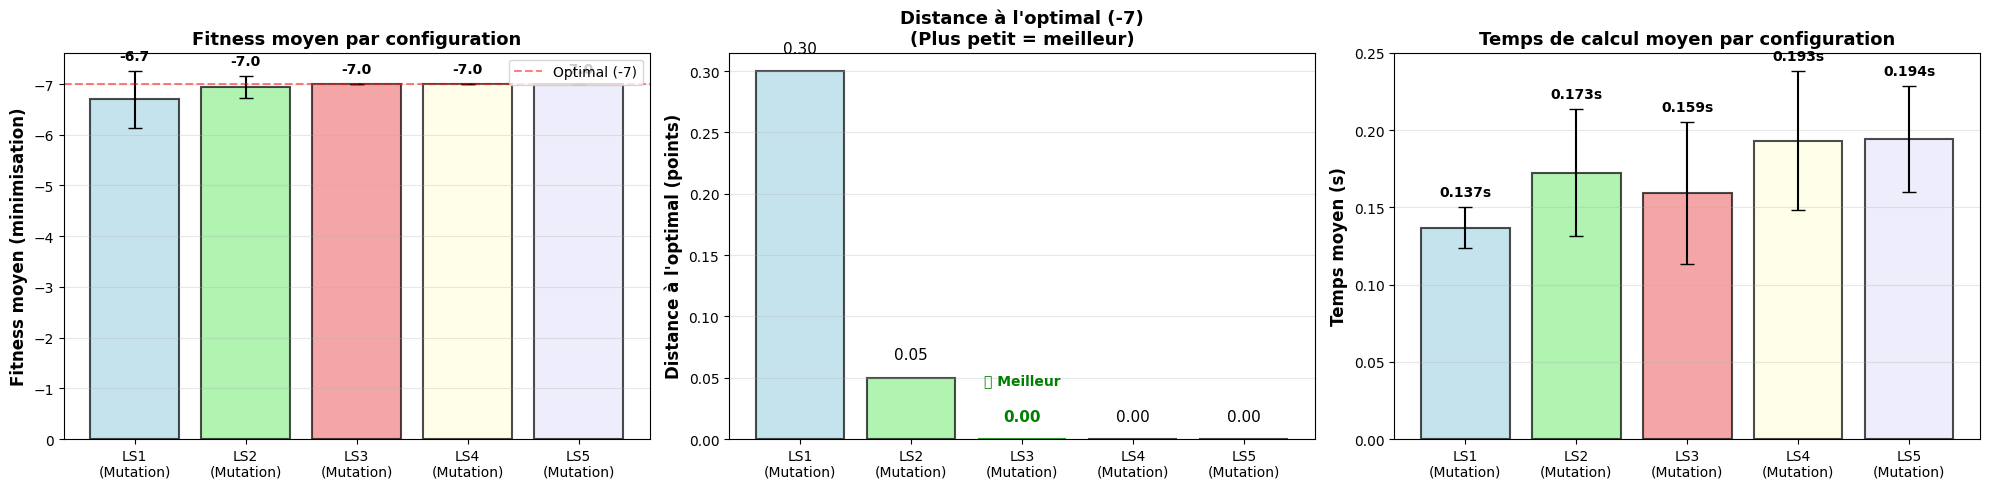


✓ Graphiques complémentaires générés

ANALYSE DES DISTANCES À L'OPTIMAL
LS3 : 0.00 points de l'optimal
LS4 : 0.00 points de l'optimal
LS5 : 0.00 points de l'optimal
LS2 : 0.05 points de l'optimal
LS1 : 0.30 points de l'optimal


In [11]:
# Graphiques complémentaires : Moyenne + Distance + Temps
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

configs = list(configurations.keys())
means = [results[c]['mean'] for c in configs]
stds = [results[c]['std'] for c in configs]
x_pos = np.arange(len(configs))

# Graphique 1 : Barres des moyennes avec écart-type
axes[0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
           color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[0].set_ylabel('Fitness moyen (minimisation)', fontsize=12, fontweight='bold')
axes[0].set_title('Fitness moyen par configuration', fontsize=13, fontweight='bold')

# Inverser l'axe Y
axes[0].invert_yaxis()

# Ligne de référence
axes[0].axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', alpha=0.5, 
                label=f'Optimal ({OPTIMAL_VALUE})')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend(loc='upper right')

# Ajout des valeurs sur les barres (dynamique)
text_offset = abs(OPTIMAL_VALUE) * 0.03  # 3% de la valeur optimale
for i, (m, s) in enumerate(zip(means, stds)):
    axes[0].text(i, m - s - text_offset, f'{m:.1f}', ha='center', fontsize=10, fontweight='bold')

# Graphique 2 : Distance à l'optimal
distances = [abs(OPTIMAL_VALUE - results[c]['mean']) for c in configs]
max_distance = max(distances) if distances else 1  # Éviter division par zéro

bars = axes[1].bar(x_pos, distances, alpha=0.7, color=colors,
                   edgecolor='black', linewidth=1.5)

# Mettre en vert la meilleure (distance la plus petite)
best_idx = distances.index(min(distances))
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(0.8)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[1].set_ylabel('Distance à l\'optimal (points)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distance à l\'optimal ({OPTIMAL_VALUE})\n(Plus petit = meilleur)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres (dynamique)
text_offset_dist = max_distance * 0.05  # 5% de la distance max
for i, d in enumerate(distances):
    color = 'green' if i == best_idx else 'black'
    weight = 'bold' if i == best_idx else 'normal'
    axes[1].text(i, d + text_offset_dist, f'{d:.2f}', ha='center', fontsize=11, 
                fontweight=weight, color=color)

# Annotation pour le meilleur (dynamique)
axes[1].text(best_idx, distances[best_idx] + text_offset_dist * 3, '⭐ Meilleur', 
            ha='center', fontsize=10, color='green', fontweight='bold')

# Graphique 3 : Temps de calcul moyen
times = [results[c]['time_mean'] for c in configs]
time_stds = [results[c]['time_std'] for c in configs]
max_time = max([t + ts for t, ts in zip(times, time_stds)]) if times else 1

axes[2].bar(x_pos, times, yerr=time_stds, capsize=5, alpha=0.7,
           color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[2].set_ylabel('Temps moyen (s)', fontsize=12, fontweight='bold')
axes[2].set_title('Temps de calcul moyen par configuration', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres (dynamique)
text_offset_time = max_time * 0.03  # 3% du temps max
for i, (t, ts) in enumerate(zip(times, time_stds)):
    axes[2].text(i, t + ts + text_offset_time, f'{t:.3f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
#plt.savefig('floatpairs_ls_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques complémentaires générés")

print("\n" + "="*60)
print("ANALYSE DES DISTANCES À L'OPTIMAL")
print("="*60)

# Afficher les distances triées
distances_with_names = [(configs[i], distances[i]) for i in range(len(configs))]
distances_with_names.sort(key=lambda x: x[1])

for i, (name, dist) in enumerate(distances_with_names, 1):
    print(f"{name} : {dist:.2f} points de l'optimal")

### 8.3 Évolution de la Performance selon la Probabilité de Mutation

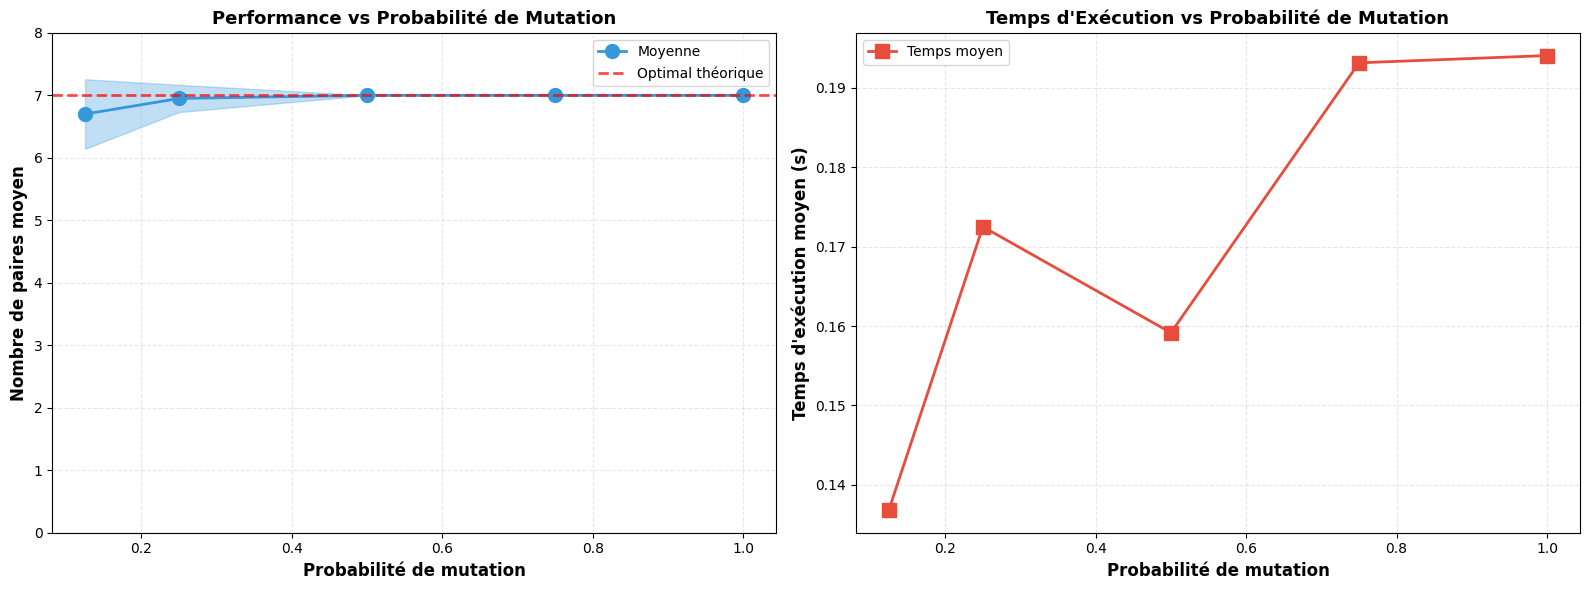

✓ Graphique 3 sauvegardé: 'floatpairs_ls_evolution.png'


In [12]:
# Graphique 3: Évolution selon probabilité de mutation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Probabilités de mutation
mutation_probs = [1.0/N_FLOATS, 0.25, 0.5, 0.75, 1.0]
config_names = list(results.keys())
means_pairs = []
stds_pairs = []
times = []

for config_name in config_names:
    means_pairs.append(-results[config_name]['mean'])
    stds_pairs.append(results[config_name]['std'])
    times.append(results[config_name]['time_mean'])

# Sous-graphique 1: Performance vs Probabilité
ax1.plot(mutation_probs, means_pairs, 'o-', linewidth=2, markersize=10, 
         color='#3498db', label='Moyenne')
ax1.fill_between(mutation_probs, 
                 [m - s for m, s in zip(means_pairs, stds_pairs)],
                 [m + s for m, s in zip(means_pairs, stds_pairs)],
                 alpha=0.3, color='#3498db')
ax1.axhline(y=-OPTIMAL_VALUE, color='red', linestyle='--', linewidth=2, 
            label='Optimal théorique', alpha=0.7)

# Limites dynamiques de l'axe Y
y_max = -OPTIMAL_VALUE + 1
ax1.set_ylim([0, y_max])

ax1.set_xlabel('Probabilité de mutation', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre de paires moyen', fontsize=12, fontweight='bold')
ax1.set_title('Performance vs Probabilité de Mutation', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Sous-graphique 2: Temps vs Probabilité
ax2.plot(mutation_probs, times, 's-', linewidth=2, markersize=10, 
         color='#e74c3c', label='Temps moyen')
ax2.set_xlabel('Probabilité de mutation', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps d\'exécution moyen (s)', fontsize=12, fontweight='bold')
ax2.set_title('Temps d\'Exécution vs Probabilité de Mutation', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
#plt.savefig('floatpairs_ls_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Graphique 3 sauvegardé: 'floatpairs_ls_evolution.png'")

## 9. Analyse Comparative des Paramètres

In [14]:
print("="*80)
print("ANALYSE COMPARATIVE DES PARAMÈTRES")
print("="*80)

# Identification de la meilleure configuration
best_config = min(results.items(), key=lambda x: x[1]['mean'])
worst_config = max(results.items(), key=lambda x: x[1]['mean'])

print(f"\n🏆 MEILLEURE CONFIGURATION: {best_config[0]}")
print(f"   Description: {configurations[best_config[0]]['nom']}")
print(f"   Moyenne: {-best_config[1]['mean']:.2f} paires")
print(f"   Taux de succès: {best_config[1]['success_rate']:.1f}%")

print(f"\n❌ MOINS BONNE CONFIGURATION: {worst_config[0]}")
print(f"   Description: {configurations[worst_config[0]]['nom']}")
print(f"   Moyenne: {-worst_config[1]['mean']:.2f} paires")
print(f"   Taux de succès: {worst_config[1]['success_rate']:.1f}%")

# Analyse de l'effet de la probabilité de mutation
print("\n" + "="*80)
print("EFFET DE LA PROBABILITÉ DE MUTATION")
print("="*80)

for i, config_name in enumerate(config_names):
    pairs = -results[config_name]['mean']
    prob = mutation_probs[i]
    print(f"\n{config_name} (p={prob:.3f}): {pairs:.2f} paires")
    
    if pairs == -OPTIMAL_VALUE:
        print("   → Atteint l'optimal en moyenne ! ✓")
    else:
        distance = abs(-OPTIMAL_VALUE - pairs)
        print(f"   → Distance à l'optimal: {distance:.2f} paires")

print("\n" + "="*80)
print("OBSERVATIONS GÉNÉRALES")
print("="*80)
print("""
1. L'impact de la probabilité de mutation sur la recherche locale
2. Trade-off entre exploration (forte mutation) et exploitation (faible mutation)
3. La recherche locale converge rapidement mais peut rester dans un optimum local
4. Le temps d'exécution varie selon la probabilité de mutation
""")

print("="*80)

ANALYSE COMPARATIVE DES PARAMÈTRES

🏆 MEILLEURE CONFIGURATION: LS3
   Description: Mutation modérée (0.5)
   Moyenne: 7.00 paires
   Taux de succès: 100.0%

❌ MOINS BONNE CONFIGURATION: LS1
   Description: Mutation par défaut (1/n)
   Moyenne: 6.70 paires
   Taux de succès: 75.0%

EFFET DE LA PROBABILITÉ DE MUTATION

LS1 (p=0.125): 6.70 paires
   → Distance à l'optimal: 0.30 paires

LS2 (p=0.250): 6.95 paires
   → Distance à l'optimal: 0.05 paires

LS3 (p=0.500): 7.00 paires
   → Atteint l'optimal en moyenne ! ✓

LS4 (p=0.750): 7.00 paires
   → Atteint l'optimal en moyenne ! ✓

LS5 (p=1.000): 7.00 paires
   → Atteint l'optimal en moyenne ! ✓

OBSERVATIONS GÉNÉRALES

1. L'impact de la probabilité de mutation sur la recherche locale
2. Trade-off entre exploration (forte mutation) et exploitation (faible mutation)
3. La recherche locale converge rapidement mais peut rester dans un optimum local
4. Le temps d'exécution varie selon la probabilité de mutation



## 10. Export des Résultats Détaillés

In [15]:
# Export des données détaillées pour chaque configuration
for config_name, res in results.items():
    detailed_df = pd.DataFrame({
        'Run': range(1, N_RUNS + 1),
        'Fitness': res['fitness_values'],
        'Pairs': [-f for f in res['fitness_values']],
        'Execution_Time': res['execution_times']
    })
    filename = f'floatpairs_ls_{config_name}_detailed.csv'
    detailed_df.to_csv(filename, index=False)
    print(f"✓ Détails de {config_name} exportés dans '{filename}'")

print("\n✓ Tous les fichiers ont été exportés avec succès !")

✓ Détails de LS1 exportés dans 'floatpairs_ls_LS1_detailed.csv'
✓ Détails de LS2 exportés dans 'floatpairs_ls_LS2_detailed.csv'
✓ Détails de LS3 exportés dans 'floatpairs_ls_LS3_detailed.csv'
✓ Détails de LS4 exportés dans 'floatpairs_ls_LS4_detailed.csv'
✓ Détails de LS5 exportés dans 'floatpairs_ls_LS5_detailed.csv'

✓ Tous les fichiers ont été exportés avec succès !
